#IMPORT

In [ ]:
import os
import numpy as np
import tensorflow as tf
from google.colab import drive
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import optimizers, regularizers
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#GPU

In [ ]:
print("Tensorflow version %s" %tf.__version__)

device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.15.0
Found GPU at: /device:GPU:0


#LOAD DATA

In [ ]:
datagen_dataset = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

dataset_generator = datagen_dataset.flow_from_directory(
    "/content/drive/My Drive/Colab Notebooks/Machine Learning Exercises/Homework_2/Dataset/train",
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen_test.flow_from_directory(
    "/content/drive/My Drive/Colab Notebooks/Machine Learning Exercises/Homework_2/Dataset/test",
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical'
)

num_samples = dataset_generator.n
num_classes = dataset_generator.num_classes
input_shape = dataset_generator.image_shape
classnames = [k for k,v in dataset_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image input (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']


Show examples

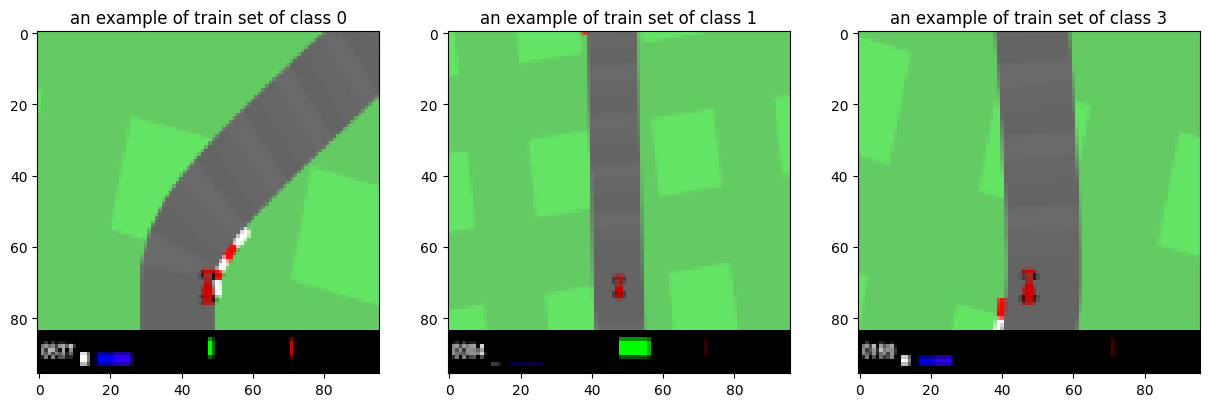

In [ ]:
x,y = dataset_generator.next()

plt.rcParams["figure.figsize"] = (15, 15)

plt.subplot(1,3,1)
plt.imshow(x[0])
plt.title("an example of train set of class " + classnames[y[0].argmax()])

plt.subplot(1,3,2)
plt.imshow(x[1])
plt.title("an example of train set of class " + classnames[y[1].argmax()])

plt.subplot(1,3,3)
plt.imshow(x[2])
plt.title("an example of train set of class " + classnames[y[2].argmax()])

plt.show()

#BALANCE CONTROL PRE

In [ ]:
def class_value(set_):
  values = {}
  for i in range(0,5):
    values[i]=0
  for class_ in set_.classes:
    values[class_]+=1
  return [int(k) for k in values.values()]

Text(0.5, 1.0, 'balance of test set')

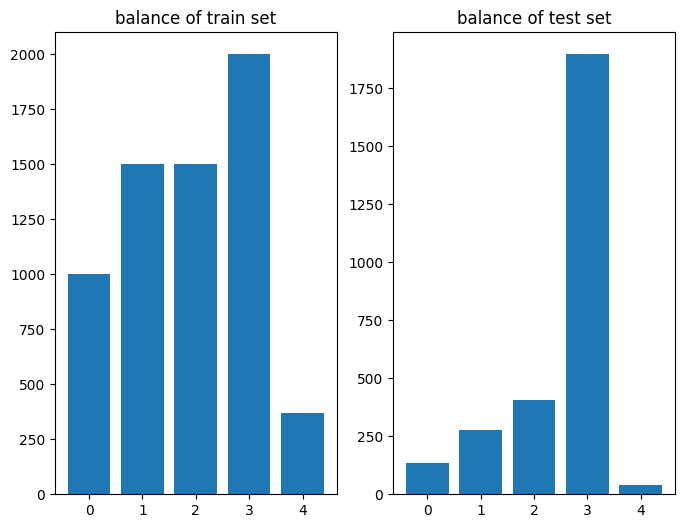

In [ ]:
train_values=class_value(dataset_generator)
test_values=class_value(test_generator)

plt.rcParams["figure.figsize"] = (8, 6)

plt.subplot(1,2,1)
plt.bar(['0','1','2','3','4'],train_values)
plt.title("balance of train set")

plt.subplot(1,2,2)
plt.bar(['0','1','2','3','4'],test_values)
plt.title("balance of test set")

#DATA AUGMENTATION

In [ ]:
datagen_train = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split=0.2,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(
    rescale=1. / 255,
)

class_directory = f'/content/drive/My Drive/Colab Notebooks/Machine Learning Exercises/Homework_2/Dataset/train/'

train_generator = datagen_train.flow_from_directory(
    class_directory,
    target_size=(96, 96),
    batch_size=256,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen_train.flow_from_directory(
    class_directory,
    target_size=(96, 96),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_directory = f'/content/drive/My Drive/Colab Notebooks/Machine Learning Exercises/Homework_2/Dataset/test/'

test_generator = datagen_test.flow_from_directory(
    class_directory,
    target_size=(96, 96),
    batch_size=2,
    class_mode='categorical',
    shuffle=False
)

Found 5096 images belonging to 5 classes.
Found 1273 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.


#MODEL

Model 1

In [ ]:
def model1(in_shape, n_classes):
  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=in_shape, padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
  model.add(Dropout(0.4))
  model.add(Dense(n_classes, activation='softmax'))

  adam = optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

model1 = model1(input_shape, num_classes)
model1.summary()
history1 = None

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 48, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

Model 2

In [ ]:
def model2(in_shape, n_classes):
  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=in_shape, padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())

  model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001)))
  model.add(Dropout(0.4))
  model.add(Dense(n_classes, activation='softmax'))

  adam = optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

model2 = model2(input_shape, num_classes)
model2.summary()
history2 = None

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 36864)             0         
                                                                 
 dense_6 (Dense)             (None, 64)               

#FIT AND HISTORY

Model 1

In [ ]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=validation_generator.n//validation_generator.batch_size+1
test_steps=test_generator.n//test_generator.batch_size
epochs = 10

h1 = model1.fit(train_generator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=val_steps)

if history1 is None:
    history1 = h1.history
else:
    history1['loss'].extend(h1.history['loss'])
    history1['accuracy'].extend(h1.history['accuracy'])
    history1['val_loss'].extend(h1.history['val_loss'])
    history1['val_accuracy'].extend(h1.history['val_accuracy'])

Epoch 1/10
19/19 [==============================] - 31s 2s/step - loss: 6.0136 - accuracy: 0.3091 - val_loss: 2.2055 - val_accuracy: 0.4705
Epoch 2/10
19/19 [==============================] - 30s 2s/step - loss: 1.8765 - accuracy: 0.4789 - val_loss: 1.5091 - val_accuracy: 0.5491
Epoch 3/10
19/19 [==============================] - 25s 1s/step - loss: 1.4159 - accuracy: 0.5304 - val_loss: 1.3240 - val_accuracy: 0.5467
Epoch 4/10
19/19 [==============================] - 25s 1s/step - loss: 1.3404 - accuracy: 0.5273 - val_loss: 1.3019 - val_accuracy: 0.5428
Epoch 5/10
19/19 [==============================] - 26s 1s/step - loss: 1.3237 - accuracy: 0.5329 - val_loss: 1.2984 - val_accuracy: 0.5460
Epoch 6/10
19/19 [==============================] - 26s 1s/step - loss: 1.3135 - accuracy: 0.5386 - val_loss: 1.2757 - val_accuracy: 0.5625
Epoch 7/10
19/19 [==============================] - 30s 2s/step - loss: 1.2868 - accuracy: 0.5479 - val_loss: 1.2833 - val_accuracy: 0.5452
Epoch 8/10
19/19 [==

Model 2

In [ ]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=validation_generator.n//validation_generator.batch_size+1
test_steps=test_generator.n//test_generator.batch_size
epochs = 10

h2 = model2.fit(train_generator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=val_steps)

if history2 is None:
    history2 = h2.history
else:
    history2['loss'].extend(h2.history['loss'])
    history2['accuracy'].extend(h2.history['accuracy'])
    history2['val_loss'].extend(h2.history['val_loss'])
    history2['val_accuracy'].extend(h2.history['val_accuracy'])

Epoch 1/10
19/19 [==============================] - 27s 1s/step - loss: 7.9591 - accuracy: 0.2793 - val_loss: 4.0743 - val_accuracy: 0.3142
Epoch 2/10
19/19 [==============================] - 26s 1s/step - loss: 2.9780 - accuracy: 0.3886 - val_loss: 2.2226 - val_accuracy: 0.5247
Epoch 3/10
19/19 [==============================] - 26s 1s/step - loss: 2.0026 - accuracy: 0.5217 - val_loss: 1.7753 - val_accuracy: 0.5515
Epoch 4/10
19/19 [==============================] - 30s 2s/step - loss: 1.7618 - accuracy: 0.5339 - val_loss: 1.6949 - val_accuracy: 0.5601
Epoch 5/10
19/19 [==============================] - 30s 2s/step - loss: 1.6757 - accuracy: 0.5333 - val_loss: 1.6291 - val_accuracy: 0.5617
Epoch 6/10
19/19 [==============================] - 30s 2s/step - loss: 1.6167 - accuracy: 0.5508 - val_loss: 1.6049 - val_accuracy: 0.5499
Epoch 7/10
19/19 [==============================] - 26s 1s/step - loss: 1.5984 - accuracy: 0.5529 - val_loss: 1.5837 - val_accuracy: 0.5609
Epoch 8/10
19/19 [==

#EVALUATIONS

accuracy test set

In [ ]:
test_steps=test_generator.n//test_generator.batch_size+1
model1.evaluate(test_generator,steps=test_steps)

1375/1375 [==============================] - 8s 5ms/step - loss: 1.1236 - accuracy: 0.6515


[1.123558759689331, 0.6515096426010132]

In [ ]:
test_steps=test_generator.n//test_generator.batch_size+1
model2.evaluate(test_generator,steps=test_steps)

1375/1375 [==============================] - 7s 5ms/step - loss: 1.3351 - accuracy: 0.6802


[1.3350826501846313, 0.6802473664283752]

classification report

In [ ]:
preds = model1.predict(test_generator)

Ypred1 = np.argmax(preds, axis=1)
Ytest1 = test_generator.classes

print(classification_report(Ytest1, Ypred1, labels=None, digits=3))

1375/1375 [==============================] - 8s 5ms/step
              precision    recall  f1-score   support

           0      0.333     0.008     0.015       133
           1      0.368     0.502     0.425       275
           2      0.416     0.741     0.533       406
           3      0.825     0.712     0.764      1896
           4      0.083     0.026     0.039        39

    accuracy                          0.652      2749
   macro avg      0.405     0.398     0.355      2749
weighted avg      0.685     0.652     0.650      2749



In [ ]:
preds = model2.predict(test_generator)

Ypred2 = np.argmax(preds, axis=1)
Ytest2 = test_generator.classes

print(classification_report(Ytest2, Ypred2, labels=None, digits=3))

1375/1375 [==============================] - 7s 5ms/step
              precision    recall  f1-score   support

           0      0.352     0.278     0.311       133
           1      0.385     0.353     0.368       275
           2      0.449     0.687     0.543       406
           3      0.823     0.768     0.795      1896
           4      0.000     0.000     0.000        39

    accuracy                          0.680      2749
   macro avg      0.402     0.417     0.403      2749
weighted avg      0.690     0.680     0.680      2749



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy and loss plots

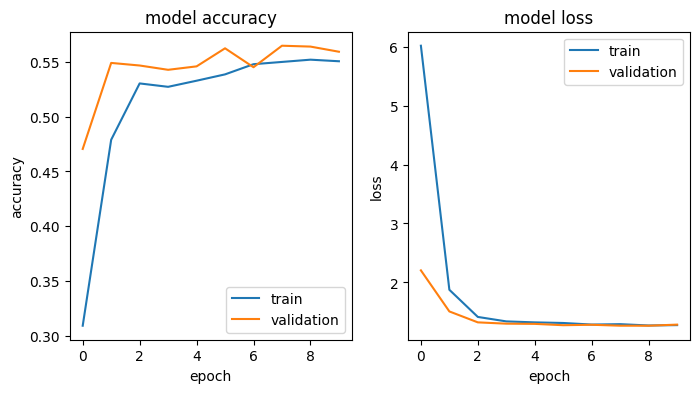

In [ ]:
plt.rcParams["figure.figsize"] = (8, 4)

plt.subplot(1,2,1)
plt.plot(history1['accuracy'])
plt.plot(history1['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history1['loss'])
plt.plot(history1['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

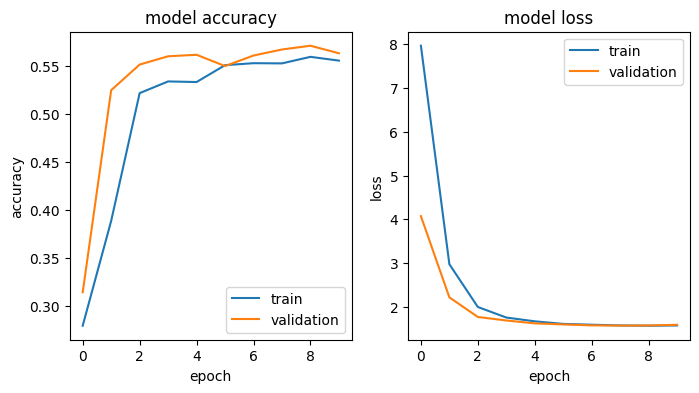

In [ ]:
plt.rcParams["figure.figsize"] = (8, 4)

plt.subplot(1,2,1)
plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.subplot(1,2,2)
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

Confusion Matrix

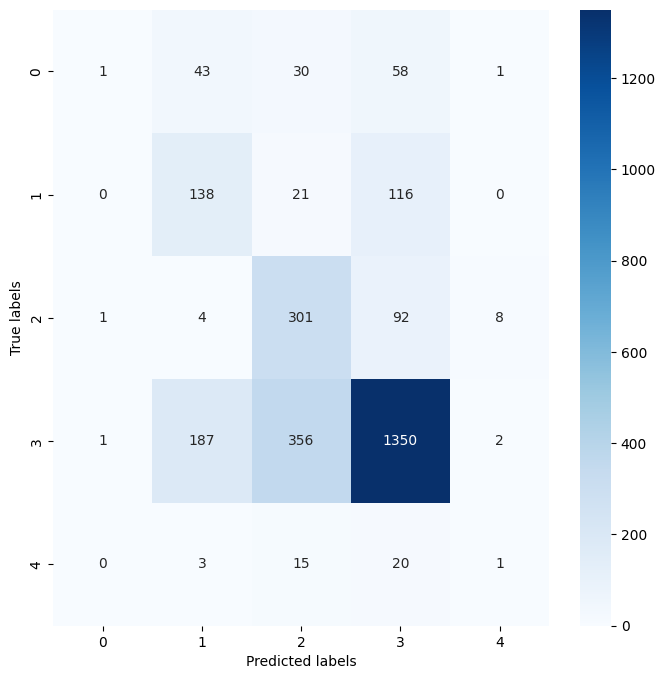

In [ ]:
cm = confusion_matrix(Ytest1, Ypred1)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

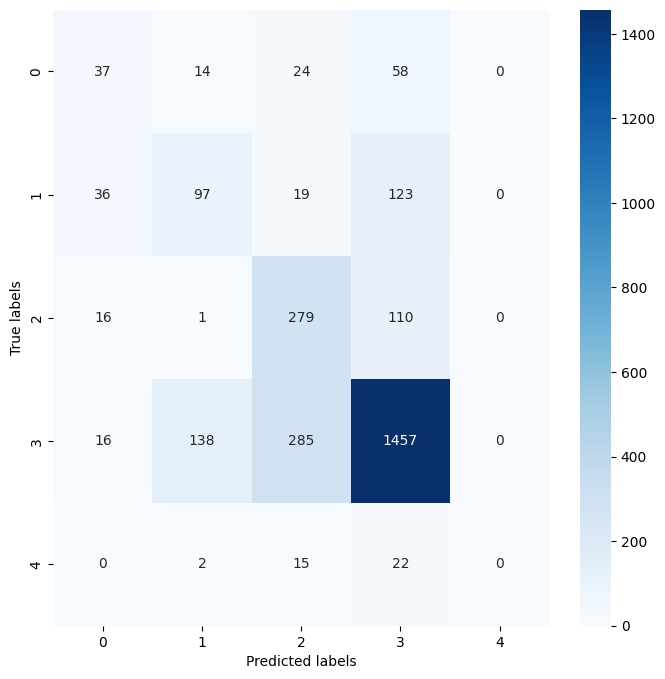

In [ ]:
cm = confusion_matrix(Ytest2, Ypred2)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()